In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

In [ ]:
# exact solution u(x) for pde
def func_u(x):
    lens=x.shape[0]
    u=torch.Tensor(lens,1)
    for i in range(lens):
        u[i]=-((x[i,0]**2)+(x[i,1]**2))/4
    return u 

# f(x) = 1
def func_f(x):
    f = 1
    return (f)

# g(x) = func_u(x_boundary)

# w_val
def func_w(x):
  lens = x.shape[0]
  w_bool = torch.gt(1 - torch.abs(x[:, 0]), torch.zeros(lens)) & torch.gt(torch.abs(x[:, 0]), torch.zeros(lens))\
           & torch.gt(1 - torch.abs(x[:, 1]), torch.zeros(lens)) & torch.gt(torch.abs(x[:, 1]), torch.zeros(lens))
  w_val = torch.where(w_bool, 1 - torch.abs(x[:, 0]) + torch.abs(x[:, 0]) + 1 - torch.abs(x[:, 1]) +
                      torch.abs(x[:, 1]),torch.zeros(lens))
  return (w_val)



# define generator and discriminator neural network
class generator(torch.nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        self.hidden00=torch.nn.Linear(dim, u_hidden_size)
        self.hidden0=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden1=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden2=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden3=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden4=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden5=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden6=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.predict=torch.nn.Linear(u_hidden_size, out_size)
    def forward(self, x):
        x=torch.tanh(self.hidden00(x))
        x=torch.tanh(self.hidden0(x))
        x=F.softplus(self.hidden1(x))
        x=torch.sin(self.hidden2(x))
        x=F.softplus(self.hidden3(x))
        x=torch.sin(self.hidden4(x))
        x=F.softplus(self.hidden5(x))
        x=torch.sin(self.hidden6(x))
        x=self.predict(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)

class discriminator(torch.nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.hidden00_v=torch.nn.Linear(dim, v_hidden_size)
        self.hidden0_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden1_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden2_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden3_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden4_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden5_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden6_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.predict_v=torch.nn.Linear(v_hidden_size, out_size)

    def forward(self, x):
        x=torch.tanh(self.hidden00_v(x))
        x=torch.tanh(self.hidden0_v(x))
        x=F.softplus(self.hidden1_v(x))
        x=torch.sin(self.hidden2_v(x))
        x=F.softplus(self.hidden3_v(x))
        x=torch.sin(self.hidden4_v(x))
        x=F.softplus(self.hidden5_v(x))
        x=torch.sin(self.hidden6_v(x))
        x=self.predict_v(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)


# grad_u
def grad_u(y_output_u):
    optimizer_u_0.zero_grad()
    lens = x_test.shape[0]
    y_output_u.backward(torch.ones([lens,1]), retain_graph=True)
    grad_u = x_test_.grad
    return(grad_u)  

# grad_phi
def grad_phi(y_output_v):
  optimizer_v_0.zero_grad()
  lens = x_test.shape[0]
  w = torch.reshape(func_w(x_test_), (lens, 1))
  phi = y_output_v.mul(w)
  phi.backward(torch.ones([lens, 1]), retain_graph=True)
  grad_phi = x_test_.grad
  return (grad_phi)



# loss function
def I(y_output_u, y_output_v):
    temp_grad_u=grad_u(y_output_u)
    t1 = torch.sum(torch.mm(torch.transpose(temp_grad_u,0,1),grad_phi(y_output_v)))
    t = torch.sum(func_f(x_test)*y_output_v)
    I = t1-t
    return(I)

def L_int(y_output_u, y_output_v):
    numerator = torch.log(torch.abs(I(y_output_u, y_output_v))**2)
    denominator = torch.log(torch.sum((y_output_v)**2)) #net_v(x_domain)
    ratio=numerator-denominator
    return(ratio)

def L_bd():
    result = torch.mean((net_u(x_boundary_)-func_u(x_boundary))**2)
    return(result)

def Loss_u(y_output_u, y_output_v):
    return(L_int(y_output_u, y_output_v)+25*L_bd())

def Loss_v(y_output_u,y_output_v):
    return(-L_int(y_output_u, y_output_v))


In [ ]:
# initial parameters(modified***)
up= 1.0
low= 0
dim= 2
mesh_size= 256
domain_size= 10000
bound_size= 2500#(*2*dim)
#
v_layer= 6
v_hidden_size= 20
v_step= 1       
v_rate=0.015   
u_layer= 6
u_hidden_size= 20
u_step= 1
u_rate=0.015
out_size=1



# x value in domain and boundary
# x_domain
x_domain=torch.Tensor(domain_size,dim).uniform_(low,up)
# x_boundary
x_boundary_list=[]  #x_boundry
for i in range(dim):
    x_bound= torch.Tensor(bound_size,dim).uniform_(low,up)
    x_bound[:,i]= up
    x_boundary_list.append(x_bound)
    x_bound= torch.Tensor(bound_size,dim).uniform_(low,up)
    x_bound[:,i]= low
    x_boundary_list.append(x_bound)
x_boundary= torch.cat(x_boundary_list, 0)

# x value for network input
x_mesh=torch.linspace(low,up,mesh_size, requires_grad=True)
mesh1 ,mesh2 = torch.meshgrid(x_mesh,x_mesh)
mesh_1= torch.reshape(mesh1, [-1,1])
mesh_2= torch.reshape(mesh2, [-1,1])
x_test= torch.cat((mesh_1,mesh_2),1)

# integration domain
int_dm = (up-low)**dim 



# torch variables
x_test_ = Variable(x_test)
x_test_.requires_grad_(True)
x_boundary_ = Variable(x_boundary)
u_test = func_u(x_test)
u_test_ = Variable(u_test)



# neural network models
net_u= generator()
net_v=discriminator()

# optimizers for grad_u and grad_phi
optimizer_u_0 = torch.optim.SGD(net_u.parameters(), lr = 0)
optimizer_v_0 = torch.optim.SGD(net_v.parameters(), lr = 0)

#optimizers for WAN
optimizer_u = torch.optim.Adam(net_u.parameters(), lr = u_rate) 
optimizer_v = torch.optim.Adam(net_v.parameters(), lr = v_rate)
# learning rate decays when loss doesn't change in 10 iterations
#scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_u, mode='max', factor=0.6, patience=150, verbose=False, threshold=1e-04, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
#scheduler_v = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_v, mode='min', factor=0.6, patience=150, verbose=False, threshold=1e-04, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

scheduler_u=torch.optim.lr_scheduler.StepLR(optimizer_u, step_size=600, gamma=0.6, last_epoch=-1) 
scheduler_v=torch.optim.lr_scheduler.StepLR(optimizer_v, step_size=600, gamma=0.6, last_epoch=-1)

In [ ]:
start =time.clock()

iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)

for t in range(iteration):
    
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u,prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
      print(t, loss_u, loss_v)
      print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
      print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

end = time.clock()
print('Running time: %s Seconds'%(end-start))

0 tensor(11.9582, grad_fn=<AddBackward0>) tensor(-11.0901, grad_fn=<NegBackward>)
第0个epoch的学习率：0.015000
第0个epoch的学习率：0.015000
10 tensor(24.5794, grad_fn=<AddBackward0>) tensor(-27.2935, grad_fn=<NegBackward>)
第10个epoch的学习率：0.015000
第10个epoch的学习率：0.015000
20 tensor(38.6313, grad_fn=<AddBackward0>) tensor(-40.5819, grad_fn=<NegBackward>)
第20个epoch的学习率：0.015000
第20个epoch的学习率：0.015000
30 tensor(38.5474, grad_fn=<AddBackward0>) tensor(-38.4703, grad_fn=<NegBackward>)
第30个epoch的学习率：0.015000
第30个epoch的学习率：0.015000
40 tensor(41.0942, grad_fn=<AddBackward0>) tensor(-42.6739, grad_fn=<NegBackward>)
第40个epoch的学习率：0.015000
第40个epoch的学习率：0.015000
50 tensor(39.3937, grad_fn=<AddBackward0>) tensor(-42.9059, grad_fn=<NegBackward>)
第50个epoch的学习率：0.015000
第50个epoch的学习率：0.015000
60 tensor(41.1213, grad_fn=<AddBackward0>) tensor(-39.5137, grad_fn=<NegBackward>)
第60个epoch的学习率：0.009000
第60个epoch的学习率：0.009000
70 tensor(40.4271, grad_fn=<AddBackward0>) tensor(-42.6329, grad_fn=<NegBackward>)
第70个epoch的学习率：0.0

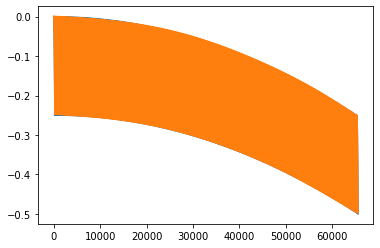

In [5]:
plt.plot(u_test_.data.numpy())
plt.plot(prediction_u.data.numpy())

In [6]:
# error and relative error
lens=x_test.shape[0]
error_test = torch.Tensor(lens,1)
for i in range(lens):
  error_test[i] = torch.sqrt((torch.square(u_test_.data[i]-prediction_u.data[i]))) 

error_r = torch.Tensor(lens,1)
u_norm= torch.sqrt(torch.mean(torch.square(u_test_.data)))
for i in range(lens):
  error_r[i]=error_test[i]/u_norm

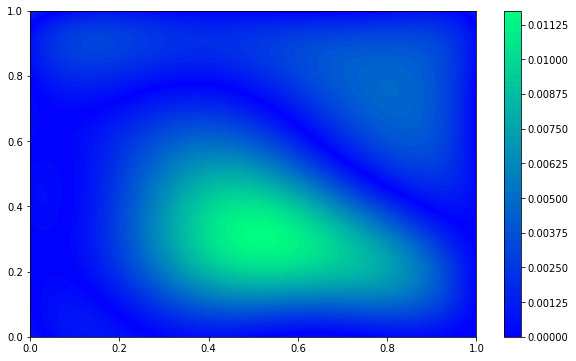

In [8]:
error_test_=torch.reshape(error_test,(256,256))
#设置打开画布大小,长10，宽6
plt.figure(figsize=(10,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),mesh2.data.numpy(),error_test_.data.numpy(), 50, cmap='winter')
#画等高线
#plt.contour(mesh1,mesh2,error_test_, 50)
#设置颜色条
plt.colorbar(cset)
plt.show()

In [9]:
# save data
import os
import scipy.io

# connect google dirve
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab_Notebooks')
file_path= './problem_data/'   #文件路径为当前运行目录下的/problem_data/
# 
data_save = {}
data_save['mesh1'] = mesh1.data.numpy()
data_save['mesh2'] = mesh2.data.numpy()
data_save['test_x'] = x_test_.data.numpy()  
data_save['test_u'] = u_test_.data.numpy()  
data_save['pred_u'] = prediction_u.data.numpy()    
data_save['error_l2'] = error_test.numpy()
data_save['error_l2r'] = error_r.numpy()  
# save data as .mat form
scipy.io.savemat(file_path+'rectangular_plate', data_save)
print('Data saved in '+file_path)

Mounted at /content/drive
Data saved in ./problem_data/
